In [1]:
import numpy as np
import h5py
import scipy.io
import keras as K
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.engine.input_layer import Input
from keras.regularizers import l2, l1
from keras.constraints import maxnorm
from keras.models import Model, load_model
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import metrics
import keras_metrics
import tensorflow as tf
from keras.utils import to_categorical
from keras.backend.tensorflow_backend import set_session
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, f1_score, auc, confusion_matrix
from keras.callbacks import TensorBoard
from time import time

/home/sn446/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import os

class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [4]:
from tensorboard.plugins.pr_curve import summary as pr_summary


class PRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        # One extra argument to indicate whether or not to use the PR curve summary.
        self.pr_curve = kwargs.pop('pr_curve', True)
        super(PRTensorBoard, self).__init__(*args, **kwargs)

        global tf
        import tensorflow as tf

    def set_model(self, model):
        super(PRTensorBoard, self).set_model(model)

        if self.pr_curve:
            # Get the prediction and label tensor placeholders.
            predictions = self.model._feed_outputs[0]
            labels = tf.cast(self.model._feed_targets[0], tf.bool)
            # Create the PR summary OP.
            self.pr_summary = pr_summary.op(name='pr_curve',
                                            predictions=predictions,
                                            labels=labels,
                                            display_name='Precision-Recall Curve')

    def on_epoch_end(self, epoch, logs=None):
        super(PRTensorBoard, self).on_epoch_end(epoch, logs)

        if self.pr_curve and self.validation_data:
            # Get the tensors again.
            tensors = self.model._feed_targets + self.model._feed_outputs
            # Predict the output.
            predictions = self.model.predict(self.validation_data[:-2])
            # Build the dictionary mapping the tensor to the data.
            val_data = [self.validation_data[-2], predictions]
            feed_dict = dict(zip(tensors, val_data))
            # Run and add summary.
            result = self.sess.run([self.pr_summary], feed_dict=feed_dict)
            self.writer.add_summary(result[0], epoch)
        self.writer.flush()

In [5]:
# Limit GPU usage
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [6]:
def create_weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        b_ce = K.losses.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.backend.mean(weighted_b_ce)

    return weighted_binary_crossentropy

In [8]:
import keras.losses
keras.losses.custom_loss = focal_loss_fixed

In [7]:
def focal_loss_fixed(y_true, y_pred):
        gamma = 2.
        alpha = 0.25
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        print("hello")
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        print("world")
        return -K.backend.sum(alpha * K.backend.pow(1. - pt_1, gamma) * K.backend.log(pt_1))-K.backend.sum((1-alpha) * K.backend.pow( pt_0, gamma) * K.backend.log(1. - pt_0))

In [9]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        print("hello")
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        print("world")
        return -K.backend.sum(alpha * K.backend.pow(1. - pt_1, gamma) * K.backend.log(pt_1))-K.backend.sum((1-alpha) * K.backend.pow( pt_0, gamma) * K.backend.log(1. - pt_0))
    return focal_loss_fixed

In [10]:
# Defined a metric for determining model accuracy
class Metrics(Callback):
    def __init__(self):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
            
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average = None)
        _val_recall = recall_score(val_targ, val_predict, average = None)
        _val_precision = precision_score(val_targ, val_predict, average = None)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        #print(len(_val_precision))
        print ("-- val_f1: " + str(_val_f1) +" — val_precision: "  + str(_val_precision) + "  — val_recall: " + str(_val_recall))
        return

In [11]:
metrcs = Metrics()

In [12]:
DATA = 2200000
number = 475

In [13]:
print('loading training data')
trainmat = h5py.File('../data/res_train.mat')
#xtr = np.transpose(np.array(trainmat['trainxdata'][:,:,DATA:]), axes=(2,0,1))
#ytr = np.array(trainmat['traindata'][0,DATA:]).T
print('finished loading training data')

loading training data
finished loading training data


In [41]:
y = trainmat['traindata'][number]
ind = np.argwhere(y==1)
ind = ind.reshape(ind.shape[0])
print(len(ind))
x_negs = np.random.randint(0,4400000, int(len(ind)*12))

25202


In [15]:
print('loading validation data')
validmat = scipy.io.loadmat('../data/res_valid.mat')
print('finished loading validation data')
sum(validmat['validdata'][:,number])

loading validation data
finished loading validation data


46

In [16]:
print('loading validation data')
testmat = scipy.io.loadmat('../data/test.mat')
print('finished loading validation data')

loading validation data
finished loading validation data


In [42]:
sum(testmat['testdata'][:,number])

2598

In [43]:
index = np.argmax(ind > DATA)
x_negs.sort()
index_b = np.argmax(x_negs > DATA)

In [44]:
x_in = trainmat['trainxdata'][:,:,:DATA]

In [45]:
x_a1 = x_in[:,:,ind[:index]]
x_b1 = x_in[:,:,x_negs[:index_b]]
x_a1 = np.transpose(x_a1, axes=(2,0,1))
x_b1 = np.transpose(x_b1, axes=(2,0,1))

In [46]:
x_in = 0
x_in = trainmat['trainxdata'][:,:,DATA:]

In [47]:
x_a2 = x_in[:,:,ind[index:]-DATA]
x_b2 = x_in[:,:,x_negs[index_b:]-DATA]
x_a2 = np.transpose(x_a2, axes=(2,0,1))
x_b2 = np.transpose(x_b2, axes=(2,0,1))


In [48]:
x_train_pos = np.vstack([x_a1,x_a2])
x_train_neg = np.vstack([x_b1,x_b2])
x_train = np.vstack([x_train_pos, x_train_neg])

In [49]:
y_train_pos = y[ind]
y_train_neg = y[x_negs]
y_train = np.concatenate([y_train_pos, y_train_neg])

In [50]:
np.save("x_train_" + str(number), x_train)
np.save("y_train_" + str(number), y_train)

In [92]:
x_train = np.load("x_train_"+str(345)+".npy")
y_train = np.load("y_train_"+str(345)+".npy")

In [93]:
x = Input(shape = (200,4))
conv1 = Convolution1D(name = "conv1", filters=128,
                        padding="same",
                        activation="relu",
                        kernel_size=5,
                         kernel_initializer=K.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None))
conv2 = Convolution1D(name = "conv2", filters=128,
                        padding="same",
                        activation="relu",
                        kernel_size=5,
                         kernel_initializer=K.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None))
conv3 = Convolution1D(name = "conv3", filters=128,
                        padding="same",
                        activation="relu",
                        kernel_size=5, 
                     kernel_initializer=K.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None))
max1 = MaxPooling1D(name = "pool1", pool_size=13, strides=13)
dropout1 = Dropout(0.2, name = "dropout1")
conv4 = Convolution1D(name = "conv4", filters=128,
                        padding="same",
                        activation="relu",
                        kernel_size=5,
                         kernel_initializer=K.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None))
conv5 = Convolution1D(name = "conv5", filters=128,
                        padding="same",
                        activation="relu",
                        kernel_size=5,
                         kernel_initializer=K.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None))
max2 = MaxPooling1D(pool_size=5, strides = 2, name = "pool2")
dropout2 = Dropout(0.2, name = "dropout2")
flatten1 = Flatten(name = "flatten1")
dense1 = Dense(32, name="dense1")
dense2 = Dense(10, activation = 'relu', name = "dense2")
dense3 = Dense(2, activation = 'softmax', name = "dense3")

In [94]:
#Create the model connections
y1 = conv1(x)
y2 = conv2(y1)
y22 = conv3(y2)
y3 = K.layers.add([y1, y22])
y4 = max1(y3)
y5 = dropout1(y4)
y6 = conv4(y5)
y7 = conv5(y6)
y8 = K.layers.add([y5, y7])
y9 = max2(y8)
y10 = dropout2(y9)
y11 = flatten1(y10)
y12 = dense1(y11)
y13 = dense2(y12)
y14 = dense3(y13)
# model = Sequential()
# model.add(Convolution1D(16, 3, input_shape=(200, 4), padding='same', name='conv1'))
# model.add(Activation('relu', name='a1'))
# model.add(MaxPooling1D())
# model.add(Convolution1D(24, 3, padding='same', name='conv2'))
# model.add(Activation('relu', name='a2'))
# model.add(MaxPooling1D())
# model.add(Convolution1D(32, 3, padding='same', name='conv3'))
# model.add(Activation('relu', name='a3'))
# model.add(MaxPooling1D())
# model.add(Flatten())
# model.add(Dense(2, name='fc1'))
# model.add(Dropout(0.2))
# model.add(Activation('softmax', name = 'a4'))

In [114]:
model = Model(x, y14)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [115]:
model.optimizer.lr

<tf.Variable 'Adam_14/lr:0' shape=() dtype=float32_ref>

In [105]:
number = 345

In [110]:
checkpointer = ModelCheckpoint(filepath="final_balanced_"+str(number)+".hdf5", verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

In [111]:
# Create validation dataset
valid_x = np.transpose(validmat['validxdata'],axes=(0,2,1))[:,400:600,:]
valid_y = validmat['validdata'][:,number]

test_x = np.transpose(testmat['testxdata'],axes=(0,2,1))[:,400:600,:]
test_y = testmat['testdata'][:,number]


#l = to_categorical(y_train)
#print(l.shape)
print(sum(valid_y)/len(valid_y))
print(sum(test_y)/len(test_y))

0.00525
0.006522732866837793


In [112]:
history = model.fit(x_train[:,400:600,:], to_categorical(y_train), 
          batch_size=512, 
          epochs=80, 
          shuffle=True, 
          validation_data=(valid_x, to_categorical(valid_y)),
          callbacks=[checkpointer,earlystopper, tensorboard])

Train on 75226 samples, validate on 8000 samples
Epoch 1/80
75226/75226 [==============================] - 4s 57us/step - loss: 0.6898 - acc: 0.5407 - val_loss: 0.6139 - val_acc: 0.9947

Epoch 00001: val_loss improved from inf to 0.61392, saving model to final_balanced_345.hdf5


AttributeError: 'int' object has no attribute 'eval'

In [32]:
fig_size = plt.rcParams["figure.figsize"] = [15, 10]

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


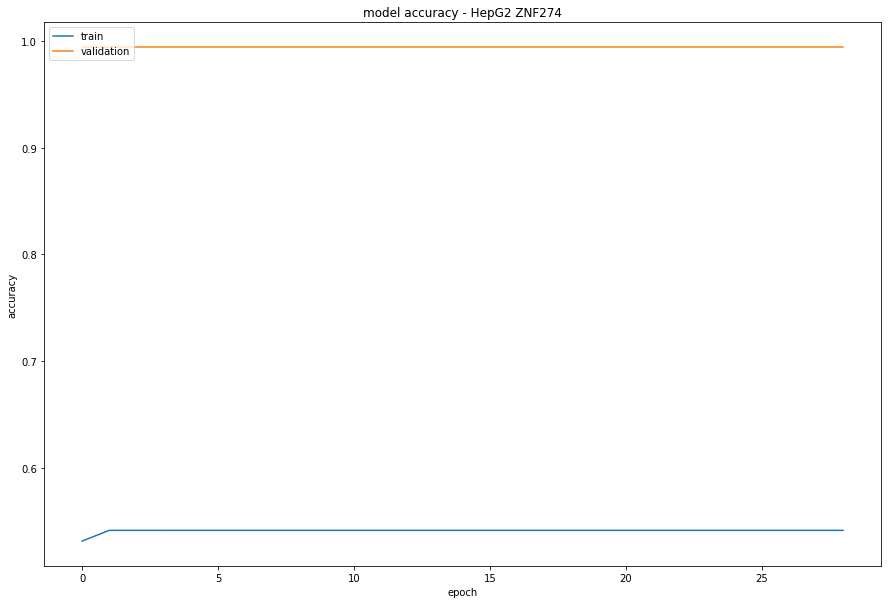

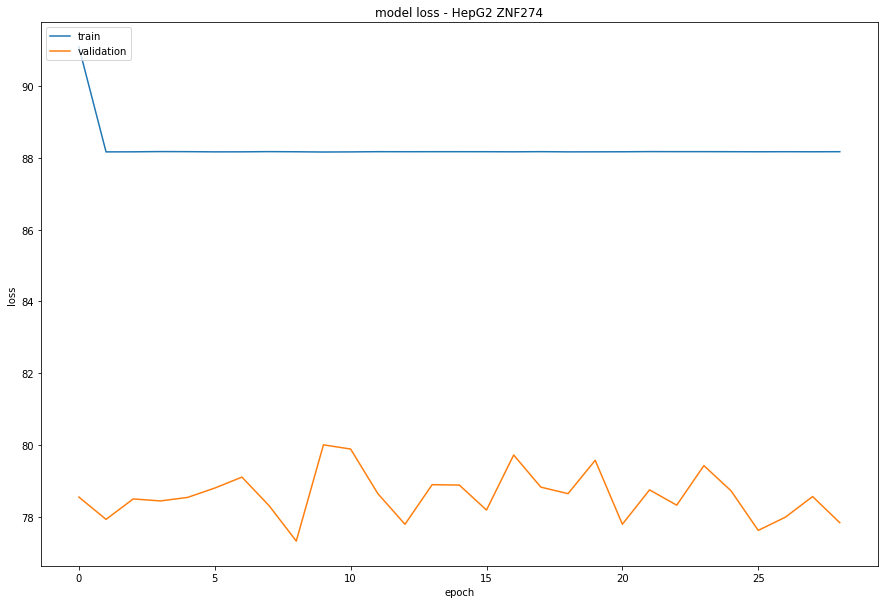

In [33]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy - HepG2 ZNF274')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss - HepG2 ZNF274')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [34]:
#number = 375

In [35]:
preds = model.predict(test_x)
print(preds.shape)
preds = preds[:,1].reshape(preds.shape[0])
print(number)
valid_labels = valid_y

(455024, 2)
475


In [557]:
# model = load_model("128_balanced_345.hdf5")

In [36]:
f1_score(test_y, preds > 0.4, pos_label=1)

0.011354349222720935

(array([     0.,      0.,      0.,      0.,      0., 455024.,      0.,
             0.,      0.,      0.]),
 array([-0.01679102,  0.08320898,  0.18320898,  0.28320898,  0.38320898,
         0.48320898,  0.58320898,  0.68320898,  0.78320898,  0.88320898,
         0.98320898]),
 <a list of 10 Patch objects>)

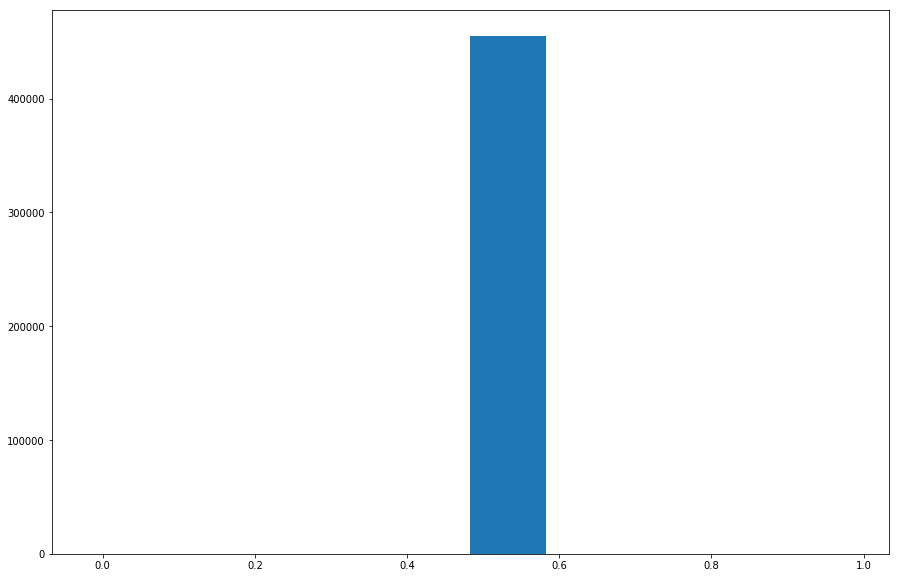

In [37]:
plt.hist(preds)

In [38]:
fpr, tpr, thresholds = roc_curve(test_y, preds, pos_label = 1)
roc_auc = auc(fpr, tpr)

In [39]:
print(roc_auc)

0.5


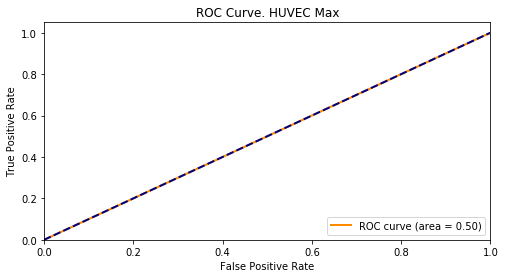

In [40]:
fig_size = plt.rcParams["figure.figsize"] = [8, 4]
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve. HUVEC Max')
plt.legend(loc="lower right")
plt.show()
#plt.savefig("roc_"+str(number))

In [585]:
confusion_matrix(test_y, preds > 0.5)

array([[343355, 107931],
       [  1163,   2575]])

In [586]:
#model = load_model('final_balanced_456.hdf5', custom_objects={'focal_loss_fixed': focal_loss_fixed})

In [587]:
import keras.backend as B
fig_size = plt.rcParams["figure.figsize"] = [150,100]

In [590]:
# class_name should be one of EI, IE or N
def visualizeClass():
    
    loss = B.mean(model.output[:,1])
    input_seq = model.input
    grads = B.gradients(loss, input_seq)[0]
    iterate = B.function([input_seq], [loss, grads])
    sequence = np.zeros((1, 200, 4))
    sequence[0] = 0.25
    #print(test_y[50])
    step_size = 2. # Gradient ascent step size
    max_sequence = np.zeros((1,200,4))
    max_output = 0
    # Perform gradient ascent in the direction of the target class
    for i in range(1500):
        if i > 250:
            step_size = 1
        loss_value, grads_value = iterate([sequence])
        print(loss_value)
        #print(grads_value.shape)
        sequence += grads_value * step_size
    
    
    #print(sequence)
    #print(sequence[0,:10])
    #print(np.linalg.norm(sequence[0], 1, axis=1))
    reshaped_seq = sequence[0].T
    #a = sequence[0].max(axis=1)
    a = np.linalg.norm(reshaped_seq, 1, axis=0)
    print(a.shape)
    reshaped_seq /= np.linalg.norm(reshaped_seq, 1, axis=0)
    # Loop:
    #for i in range(len(a)):
    #    sequence[0,i] /= a[i]
    #sequence[0] /= np.linalg.norm(sequence[0], 1, axis=0)
    
    #sequence[0] /= np.linalg.norm(sequence[0], 1, axis=0)
    #print(sequence[0, :10])
    #print(np.linalg.norm(sequence[0], 1, axis=1))
    reshaped_seq = np.clip(reshaped_seq, 0, 1)
    
    plt.title("Gradient Ascent Visualization - HUVEC Max")
    plt.imsave("maximum_"+str(number)+"_43.png", reshaped_seq)

    plt.imshow(reshaped_seq, cmap='viridis')
    #plt.xticks(np.arange(200), np.arange(200)+1)
    plt.yticks(np.arange(4), ('A', 'G', 'C', 'T'))
    # Uncomment the line below to save the figure as an image
    # plt.savefig('ClassVisualization' + class_name + '.png')
    plt.show()
    return reshaped_seq


In [591]:
number

460

0.45603025
0.4565392
0.45661068
0.456641
0.45665264
0.45665637
0.4566544
0.45666683
0.4566763
0.4566648
0.45668465
0.45668
0.45669988
0.45670614
0.45671648
0.4567249
0.45674968
0.45678487
0.4568098
0.45683444
0.4569202
0.45699844
0.4570617
0.45713097
0.45719567
0.45721808
0.45726696
0.45728004
0.45730582
0.45736885
0.45736122
0.4574279
0.45744464
0.45741397
0.45748398
0.45750502
0.4574934
0.4575332
0.4575542
0.4575645
0.45756388
0.45759386
0.4575902
0.45759904
0.45761856
0.45761845
0.45763874
0.45763522
0.45765007
0.45765585
0.45766366
0.45767596
0.4576698
0.45768738
0.45769125
0.4576951
0.45769665
0.45769596
0.45768997
0.45770434
0.4577083
0.4577107
0.45770904
0.4577111
0.4577155
0.45771593
0.45772013
0.45771974
0.4577228
0.4577254
0.457725
0.45772856
0.4577261
0.45773178
0.45773044
0.45773062
0.4577279
0.4577339
0.45773277
0.45773658
0.45775527
0.4577561
0.457765
0.45777524
0.45777887
0.45779043
0.45780256
0.45783505
0.4578821
0.45802313
0.45807624
0.4581045
0.458129
0.4581696
0.4581

0.99995685
0.99995697
0.99995697
0.9999571
0.9999571
0.9999572
0.9999572
0.9999573
0.9999573
0.99995744
0.9999577
0.9999578
0.9999579
0.99995816
0.9999583
0.9999584
0.99995863
0.99995875
0.9999589
0.999959
0.99995923
0.99995935
0.99995947
0.9999596
0.9999597
0.9999598
0.99996006
0.9999602
0.9999603
0.9999604
0.99996054
0.99996066
0.9999609
0.999961
0.99996114
0.99996126
0.9999614
0.9999615
0.9999616
0.99996185
0.999962
0.9999621
0.9999622
0.99996245
0.99996257
0.9999627
0.9999628
0.9999629
0.99996305
0.99996316
0.9999633
0.9999634
0.9999635
0.99996376
0.9999639
0.999964
0.9999641
0.99996424
0.99996436
0.9999645
0.9999646
0.9999647
0.99996483
0.99996495
0.9999651
0.9999652
0.9999654
0.99996555
0.99996567
0.9999658
0.9999659
0.999966
0.99996614
0.99996626
0.9999664
0.9999665
0.9999666
0.9999666
0.99996674
0.99996686
0.999967
0.9999671
0.9999672
0.99996734
0.99996746
0.9999676
0.9999677
0.9999678
0.99996793
0.99996805
0.99996805
0.9999682
0.9999683
0.9999684
0.9999685
0.99996865
0.9999687

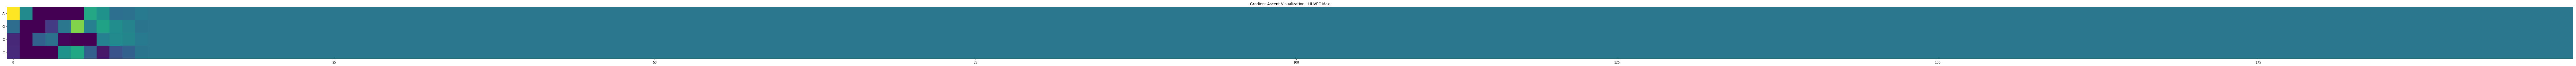

In [592]:
sq= visualizeClass()

In [379]:
sq[:,100]

array([0.25, 0.25, 0.25, 0.25])

In [355]:
sequence = np.random.normal(1,0.1, [1,4,200])
x = np.linalg.norm(sequence[0], 1, axis=0)
print(x.shape)
sequence[0] /= np.linalg.norm(sequence[0], 1, axis=0)

(200,)


In [222]:
from ann_visualizer.visualize import ann_viz

In [223]:
ann_viz(model, title="Artificial Neural network - Model Visualization")

ValueError: ANN Visualizer: Layer not supported for visualizing

In [224]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.